# 将PASCAL VOC数据集转换为车辆检测的tfrecords

In [1]:
import xml.etree.ElementTree as ET
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

## 1. 定义tfrecords的辅助函数

In [2]:
def _bytes_feature(value):
    if not isinstance(value, list):
        value = [value]
    for idx, v in enumerate(value):
        if isinstance(v, str):  # 字符串转bytes
            value[idx] = v.encode()
        if isinstance(v, type(tf.constant(0))):
            value[idx] = v.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _float_feature(value):
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
    if not isinstance(value, (tuple, list)):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

## 2. 利用PASCAL VOC2007创建TFRecord

## 2.1 定义voc的标签和工具函数

In [3]:
voc_labels = {
    'none': (0, 'Background'),
    'aeroplane': (1, 'Vehicle'),
    'bicycle': (2, 'Vehicle'),
    'bird': (3, 'Animal'),
    'boat': (4, 'Vehicle'),
    'bottle': (5, 'Indoor'),
    'bus': (6, 'Vehicle'),
    'car': (7, 'Vehicle'),
    'cat': (8, 'Animal'),
    'chair': (9, 'Indoor'),
    'cow': (10, 'Animal'),
    'diningtable': (11, 'Indoor'),
    'dog': (12, 'Animal'),
    'horse': (13, 'Animal'),
    'motorbike': (14, 'Vehicle'),
    'person': (15, 'Person'),
    'pottedplant': (16, 'Indoor'),
    'sheep': (17, 'Animal'),
    'sofa': (18, 'Indoor'),
    'train': (19, 'Vehicle'),
    'tvmonitor': (20, 'Indoor'),
}

In [4]:
"""
获取文件夹下面指定类型的文件
"""
def get_files_list(directory, suffix = ["jpg", "png"]):
    # 检查是否存在该目录
    if not os.path.exists(directory):
        print("directory not exists")
    file_list = []
    for root, dirs, files in os.walk(directory):
        # 遍历文件, 将文件放到file_list中
        for file_name in files:
            if file_name.split(".")[-1] in suffix:
                file_path = os.path.join(root, file_name)
                file_list.append(file_path)
    return file_list

In [5]:
"""
解析单个xml文件
"""
def anno_parse(file_path, _type = None):
    tree = ET.parse(file_path)
    anno = {}
    # 解析objects
    objects = []
    for obj_ele in tree.findall("object"):
        if _type != None and _type != obj_ele.find("name").text:
            continue
        obj = {}
        # 读取bbox, 顺序为[xmin, ymin, xmax, ymax]
        bbox_ele = obj_ele.find("bndbox")
        bbox = [int(bbox_ele.find("xmin").text), int(bbox_ele.find("ymin").text),
               int(bbox_ele.find("xmax").text), int(bbox_ele.find("ymax").text)]
        obj["bbox"] = bbox
        # 读取label数字标签
        obj["label"] = voc_labels[obj_ele.find("name").text][0]
        # 读取label_text文字标签
        obj["label_text"] = tf.constant(obj_ele.find("name").text)
        # 读取物体是否为较难识别
        obj["difficult"] = int(obj_ele.find("difficult").text)
        # 读取物体是否被截断
        obj["truncated"] = int(obj_ele.find("truncated").text)
        objects.append(obj)
    anno["objects"] = objects
    # 解析size
    size = {}
    size_ele = tree.find("size")
    size["width"] = int(size_ele.find("width").text)
    size["height"] = int(size_ele.find("height").text)
    size["depth"] = int(size_ele.find("depth").text)
    anno["size"] = size
    return anno

In [6]:
anno_parse(r'.\VOCtrainval_06-Nov-2007\VOCdevkit\VOC2007\Annotations\000083.xml', "car")

{'objects': [{'bbox': [109, 33, 447, 309],
   'difficult': 0,
   'label': 7,
   'label_text': <tf.Tensor: shape=(), dtype=string, numpy=b'car'>,
   'truncated': 0}],
 'size': {'depth': 3, 'height': 333, 'width': 500}}

## 2.2 处理图片和标注
返回参数：
* image_data: 图片原始数据
* shape: 图片形状元组 (h, w, c)
* bboxes: 图片中每个object的bbox
* labels： 每个object的数字标签
* labels_text： 每个object的文字标签
* difficult： 该object是否容易辨认
* truncated： 该object是否被截断

### 2.2.1 处理单个图片文件和标注

In [9]:
def proccess_single_data(directory, image_name, _type = None, directory_images = "JPEGImages/",
                         directory_annos = "Annotations/", suffix = [".jpg", ".xml"]):
    # 暂时不对image_name做任何处理
    # 读取图片
    image_data = tf.io.read_file(os.path.join(directory, directory_images, image_name + suffix[0]))
    # 按格式处理anno, 这里只是选择car
    anno = anno_parse(os.path.join(directory, directory_annos, image_name + suffix[1]), _type)
    shape = [anno["size"]["height"], anno["size"]["width"], anno["size"]["depth"]]
    bboxes = []
    labels = []
    labels_text = []
    difficult = []
    truncated = []
    for obj in anno["objects"]:
        bboxes.append(obj["bbox"])
        labels.append(obj["label"])
        labels_text.append(obj["label_text"])
        difficult.append(obj["difficult"])
        truncated.append(obj["truncated"])
    return image_name, image_data, shape, bboxes, labels, labels_text, difficult, truncated

In [10]:
image_name, image_data, shape, bboxes, labels, labels_text, difficult, truncated = proccess_single_data('./VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/', "000005")
print(image_name, shape, bboxes, labels, labels_text, difficult, truncated, sep = "\n")

000005
[375, 500, 3]
[[263, 211, 324, 339], [165, 264, 253, 372], [5, 244, 67, 374], [241, 194, 295, 299], [277, 186, 312, 220]]
[9, 9, 9, 9, 9]
[<tf.Tensor: shape=(), dtype=string, numpy=b'chair'>, <tf.Tensor: shape=(), dtype=string, numpy=b'chair'>, <tf.Tensor: shape=(), dtype=string, numpy=b'chair'>, <tf.Tensor: shape=(), dtype=string, numpy=b'chair'>, <tf.Tensor: shape=(), dtype=string, numpy=b'chair'>]
[0, 0, 1, 0, 1]
[0, 0, 1, 0, 1]


### 2.2.2 将处理好的单个图片文件和标注转换为Example

In [11]:
def convert_to_example(image_name, image_data, shape, bboxes, labels, labels_text, difficult, truncated):
    image_format = b'JPEG'
    bboxes = np.array(bboxes)
    bboxes = bboxes.flatten()
    example = tf.train.Example(features = tf.train.Features(feature={
        'height': _int64_feature(shape[0]),
        'width': _int64_feature(shape[1]),
        'channels': _int64_feature(shape[2]),
        'shape': _int64_feature(shape),
        'bboxes': _float_feature(bboxes.tolist()),  # 用float存的原因是方便后面归一化, 也可以在存之前就归一化
        'labels': _int64_feature(labels),
        'labels_text': _bytes_feature(labels_text),
        'difficult': _int64_feature(difficult),
        'truncated': _int64_feature(truncated),
        'format': _bytes_feature(image_format),
        'image_raw': _bytes_feature(image_data),
        'image_name': _bytes_feature(image_name)
    }))
    return example

## 2.3 将pascal数据集转换为tfrecords

In [17]:
def proccess_pascal_data(input_dir, output_path, _type = None, mode = "train", directory_imageSet = "ImageSets/Main/", directory_images = "JPEGImages/",
                         directory_annos = "Annotations/", suffix = [".jpg", ".xml"]):
    if _type == None:
        with open(os.path.join(input_dir, directory_imageSet, mode + ".txt")) as file:
            image_names = [image_name.strip() for image_name in file.readlines()]  # 去除后面的换行符
    else:
        with open(os.path.join(input_dir, directory_imageSet, _type + "_" + mode + ".txt")) as file:
            # 暂时只考虑为1不考虑为0的情况, 也就是比较好辨认的物体
            image_names = [image_name.strip().split()[0] for image_name in file.readlines() if image_name.strip().split()[1] == "1"]  # 去除后面的换行符
    print(image_names)
    with tf.io.TFRecordWriter(output_path) as writer:
        for image_name in image_names:
            (image_name, image_data, shape, bboxes,
            labels, labels_text, difficult, truncated) = proccess_single_data(input_dir, image_name, 
                                                                                _type,
                                                                                directory_images,
                                                                                directory_annos,
                                                                                suffix)
            example = convert_to_example(image_name, image_data, shape, bboxes, labels, labels_text, difficult, truncated)
            writer.write(example.SerializeToString())
    writer.close()

In [18]:
ds_path = r".\data\PASCAL_VOC_2007_OBJ_car_train.tfrecords"
proccess_pascal_data(r".\VOCtrainval_06-Nov-2007\VOCdevkit\VOC2007", ds_path, "car")  # 用来做车辆检测的数据集

['000012', '000026', '000047', '000083', '000091', '000134', '000153', '000159', '000161', '000220', '000262', '000263', '000288', '000296', '000311', '000317', '000320', '000334', '000355', '000367', '000387', '000404', '000406', '000431', '000469', '000474', '000522', '000541', '000554', '000590', '000605', '000620', '000672', '000688', '000700', '000818', '000823', '000829', '000860', '000871', '000888', '000906', '000977', '001057', '001060', '001112', '001119', '001237', '001258', '001268', '001294', '001334', '001364', '001384', '001385', '001409', '001414', '001455', '001488', '001492', '001494', '001532', '001559', '001576', '001604', '001622', '001662', '001676', '001699', '001780', '001821', '001845', '001881', '001902', '001937', '001954', '001980', '002056', '002116', '002134', '002153', '002170', '002178', '002180', '002182', '002197', '002241', '002247', '002291', '002307', '002311', '002355', '002373', '002411', '002420', '002436', '002478', '002490', '002533', '002534',

# 3 读取tfrecords并可视化

In [19]:
ds = tf.data.TFRecordDataset(ds_path)

In [20]:
# 创建一个描述器
image_feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'channels': tf.io.FixedLenFeature([], tf.int64),
    'bboxes': tf.io.FixedLenSequenceFeature([4], tf.float32, allow_missing=True),  # 用float存的原因是方便后面归一化, 也可以在存之前就归一化
    'labels': tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
    'labels_text': tf.io.FixedLenSequenceFeature([], tf.string, allow_missing=True),
    'image_name': tf.io.FixedLenFeature([], tf.string)
}

In [21]:
def parse_image_function(example_proto):
    # 把Example转为dict
    return tf.io.parse_single_example(example_proto, image_feature_description)

tf.Tensor(b'000012', shape=(), dtype=string)
tf.Tensor([[156.  97. 351. 270.]], shape=(1, 4), dtype=float32)
tf.Tensor([b'car'], shape=(1,), dtype=string)


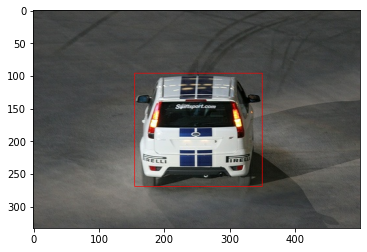

tf.Tensor(b'000026', shape=(), dtype=string)
tf.Tensor([[ 90. 125. 337. 212.]], shape=(1, 4), dtype=float32)
tf.Tensor([b'car'], shape=(1,), dtype=string)


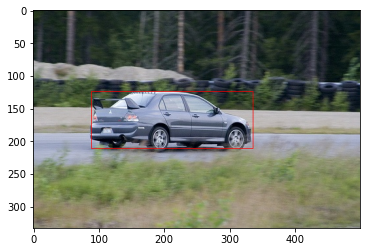

tf.Tensor(b'000047', shape=(), dtype=string)
tf.Tensor([[ 15.   1. 459. 312.]], shape=(1, 4), dtype=float32)
tf.Tensor([b'car'], shape=(1,), dtype=string)


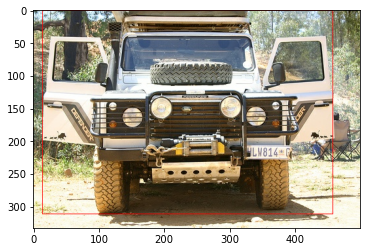

tf.Tensor(b'000083', shape=(), dtype=string)
tf.Tensor([[109.  33. 447. 309.]], shape=(1, 4), dtype=float32)
tf.Tensor([b'car'], shape=(1,), dtype=string)


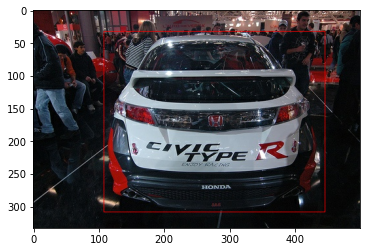

tf.Tensor(b'000091', shape=(), dtype=string)
tf.Tensor(
[[125. 241. 195. 284.]
 [ 81. 248. 105. 268.]
 [ 91. 250. 126. 274.]], shape=(3, 4), dtype=float32)
tf.Tensor([b'car' b'car' b'car'], shape=(3,), dtype=string)


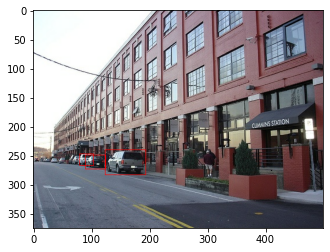

In [26]:
for d in ds.map(parse_image_function).take(5):
    print(d["image_name"])
    img = tf.image.decode_jpeg(d["image_raw"])
    bboxes = d["bboxes"]
    print(bboxes)
    print(d["labels_text"])
    width = tf.cast(d["width"], tf.float32)
    height = tf.cast(d["height"], tf.float32)
    # 绘制bboxes, 注意用tf绘制bbox与cv不一样，前者要求img和bbox均归一化
    img = tf.expand_dims(img, 0)  # Tensoflow是按照batch的方式绘制bbox，所以添加一个batch的坐标轴
    img = tf.cast(img, tf.float32) / 255.  # 归一化
    bboxes = bboxes.numpy()
    bboxes[:, 0::2] /= width
    bboxes[:, 1::2] /= height
    # Tensorflow 绘制的时候是ymin, xmin, ymax, xmax
    bboxes[:, [0, 1]] = bboxes[:, [1, 0]]
    bboxes[:, [2, 3]]  = bboxes[:, [3, 2]]
    bboxes = tf.expand_dims(bboxes, 0)
    img = tf.image.draw_bounding_boxes(img, bboxes, np.array([[1.0, 0.0, 0.0]]))
    plt.imshow(tf.squeeze(img))
    plt.show()

In [30]:
car_count = 0
d_count = 0
for d in ds.map(parse_image_function):
    for bbox in d["bboxes"]:
        car_count += d["bboxes"].shape[0]
    d_count += 1
print("车辆数目", car_count)
print("图片数目", d_count)

车辆数目 2919
图片数目 376
